In [4]:
import os
import jax
import pickle

os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=24'
jax.config.update('jax_platform_name', 'cpu')

#from jax.config import config; config.update("jax_enable_x64", True)

%load_ext autoreload
%autoreload 2

from brax import envs
from brax.io import html, model
from brax.training import normalization

import flax
import jax.numpy as jnp
from brax.envs import create_fn

from IPython.display import HTML, clear_output

import optax

import matplotlib.pyplot as plt
import numpy as np

from controllers import GruController, MlpController, LinearController

from apg import apg

from functools import partial

def visualize(sys, qps, height=480):
  """Renders a 3D visualization of the environment."""
  return HTML(html.render(sys, qps, height=height))

len(jax.devices())

save_dir = "save_1_apg"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


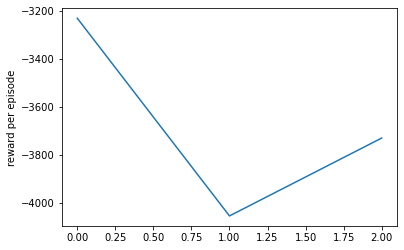

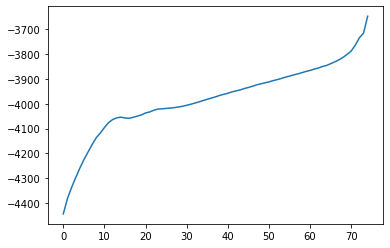

 Iteration 2 --------------------------------
0 : reward: -4432.25048828125 -> -3729.618896484375
1 : reward: -4564.505859375 -> -3971.60595703125
2 : reward: -4548.1787109375 -> -3989.986328125
3 : reward: -4813.3583984375 -> -4001.477783203125
4 : reward: -4448.5283203125 -> -4009.833740234375
5 : reward: -4648.080078125 -> -4018.27587890625
6 : reward: -4443.322265625 -> -4034.671142578125
7 : reward: -4525.318359375 -> -4057.91015625
---
8 : reward: -4731.92919921875 -> -4061.976318359375
9 : reward: -4684.6826171875 -> -4077.239990234375
10 : reward: -4584.13671875 -> -4087.15625
11 : reward: -4287.0341796875 -> -4088.264892578125
12 : reward: -4512.388671875 -> -4095.362548828125
13 : reward: -5105.0419921875 -> -4095.649658203125
14 : reward: -4517.72265625 -> -4099.96044921875
15 : reward: -4710.025390625 -> -4121.4873046875
16 : reward: -4353.58544921875 -> -4159.39599609375
17 : reward: -4363.55224609375 -> -4250.17138671875
18 : reward: -4657.19921875 -> -4677.4501953125
19 

KeyboardInterrupt: 

In [8]:
env_name = "reacher"  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'walker2d, 'ur5e', 'reacher', bball_1dof]

#for env_name in ["inverted_pendulum_swingup" , "acrobot", "inverted_double_pendulum_swingup"]:  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'walker2d, 'ur5e', 'reacher', bball_1dof]
for env_name in ['acrobot']:
    episode_length = 500
    action_repeat = 1
    env_fn = create_fn(env_name = env_name, action_repeat=action_repeat, batch_size=None, auto_reset=False)
    env = env_fn()

    policy_size = int(2**jnp.ceil(jnp.log2(env.observation_size*4)))
    print(policy_size)
    policy = GruController(env.observation_size, env.action_size, policy_size)
    pickle.dump(policy, open(f"{save_dir}/{env_name}_policy", 'wb'))
    
    for i in range(8):
        inference_fn, params, rewards = cem_apg(env_fn,
                                                20,
                                                key=jax.random.PRNGKey(i),
                                                episode_length = episode_length,
                                                action_repeat = action_repeat,
                                                batch_size = 1,
                                                truncation_length = None,
                                                learning_rate = 5e-4,
                                                clipping = 1e9,
                                                initial_std = 0.05,
                                                eps = 0.0,
                                                normalize_observations=True,
                                                policy = policy
                                               )

        model.save_params(f"{save_dir}/{env_name}_params_{i}", params)
        pickle.dump(rewards, open(f"{save_dir}/{env_name}_rewards.pkl{i}", "wb"))



In [ ]:
from brax.io import model
import ce_apg

model.save_params('/tmp/params', params)
inference_fn = ce_apg.make_inference_fn(
    env.observation_size, env.action_size, True, policy)
params = model.load_params('/tmp/params')

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=5)
state = jit_env_reset(rng=rng)
h0 = np.zeros_like(state.obs)
h = h0

while not state.done:
  rollout.append(state)
  h, act = jit_inference_fn(params, h, state.obs)
  state = jit_env_step(state, act)

HTML(html.render(env.sys, [s.qp for s in rollout]))

In [ ]:
env_name = "acrobot"  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'walker2d, 'ur5e', 'reacher', bball_1dof]

episode_length = 500
action_repeat = 1
env_fn = create_fn(env_name = env_name, action_repeat=action_repeat, batch_size=None, auto_reset=False)
env = env_fn()



policy_size = int(2**jnp.ceil(jnp.log2(env.observation_size*4)))
print(policy_size)
policy = GruController(env.observation_size, env.action_size, 32)

for i in range(8):
    normalizer_params, policy_params, rewards = cem_apg(env_fn,
                                                        200,
                                                        key=jax.random.PRNGKey(i),
                                                        episode_length = episode_length,
                                                        action_repeat = action_repeat,
                                                        apg_epochs = 75,
                                                        cem_epochs = 1,
                                                        batch_size = 1,
                                                        truncation_length = None,
                                                        learning_rate = 5e-4,
                                                        clipping = 1e9,
                                                        initial_std = 0.01,
                                                        num_elite = 8,
                                                        eps = 0.0,
                                                        normalize_observations=True,
                                                        policy = policy
                                                       )



    pickle.dump(policy_params, open(f"{save_dir}/{env_name}_policy{i}.pkl", 'wb'))
    pickle.dump(normalizer_params, open(f"{save_dir}/{env_name}_normalize{i}.pkl", 'wb'))
    pickle.dump(rewards, open(f"{save_dir}/{env_name}_rewards.pkl{i}", 'wb'))

In [ ]:
env_name = "inverted_double_pendulum_swingup"  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'walker2d, 'ur5e', 'reacher', bball_1dof]

episode_length = 500
action_repeat = 1
env_fn = create_fn(env_name = env_name, action_repeat=action_repeat, batch_size=None, auto_reset=False)
env = env_fn()



policy_size = int(2**jnp.ceil(jnp.log2(env.observation_size*4)))
print(policy_size)
policy = GruController(env.observation_size, env.action_size, 128)

for i in range(8):
    normalizer_params, policy_params, rewards = cem_apg(env_fn,
                                                        200,
                                                        key=jax.random.PRNGKey(i),
                                                        episode_length = episode_length,
                                                        action_repeat = action_repeat,
                                                        apg_epochs = 75,
                                                        cem_epochs = 1,
                                                        batch_size = 1,
                                                        truncation_length = None,
                                                        learning_rate = 5e-4,
                                                        clipping = 1e9,
                                                        initial_std = 0.01,
                                                        num_elite = 8,
                                                        eps = 0.0,
                                                        normalize_observations=True,
                                                        policy = policy
                                                       )



    pickle.dump(policy_params, open(f"{save_dir}/{env_name}_policy{i}.pkl", 'wb'))
    pickle.dump(normalizer_params, open(f"{save_dir}/{env_name}_normalize{i}.pkl", 'wb'))
    pickle.dump(rewards, open(f"{save_dir}/{env_name}_rewards.pkl{i}", 'wb'))

In [ ]:
import pickle
pickle.dump(policy_params2, open("inverted_double_pendulum_swingup.pickle", 'wb'))

In [ ]:
env_name = "inverted_double_pendulum_swingup"
pickle.dump(policy_params2, open(f"{env_name}_policy.pkl", 'wb'))
pickle.dump(normalizer_params2, open(f"{env_name}_normalize.pkl", 'wb'))
pickle.dump(rewards2, open(f"{env_name}_rewards.pkl", 'wb'))